## 커스텀 임베딩으로 weat 적용

영화 시놉시스 데이터로 임베딩 구성

일반영화, 예술영화는 lms에서 weat를 보기도 하였고, 장르가 아니고 조금 다른 구분이기 때문에 장르만 비교

In [2]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [3]:
# 명사 토크나이징
okt = Okt()
tokenized = []
with open("model/data/synopsis.txt", "r") as file:
    while True:
        line = file.readline()
        if not line:
            break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:  # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])  # 명사일 때만 tokenized 에 저장하게 됩니다.
        tokenized.append(res)

word2vec 모델


In [4]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

In [5]:
# 임베딩이 잘 되었나 확인
model.wv.most_similar(positive=["영화"])

[('작품', 0.884880781173706),
 ('다큐멘터리', 0.8529170155525208),
 ('드라마', 0.8270130753517151),
 ('영화로', 0.8062790632247925),
 ('형식', 0.8018210530281067),
 ('코미디', 0.7981148958206177),
 ('주제', 0.7893011569976807),
 ('소재', 0.781541109085083),
 ('설정', 0.7789903283119202),
 ('인터뷰', 0.7657408714294434)]

In [6]:
# 장르와 파일 목록
genre_txt = [
    "synopsis_SF.txt",
    "synopsis_family.txt",
    "synopsis_show.txt",
    "synopsis_horror.txt",
    "synopsis_etc.txt",
    "synopsis_documentary.txt",
    "synopsis_drama.txt",
    "synopsis_romance.txt",
    "synopsis_musical.txt",
    "synopsis_mystery.txt",
    "synopsis_crime.txt",
    "synopsis_historical.txt",
    "synopsis_western.txt",
    "synopsis_adult.txt",
    "synopsis_thriller.txt",
    "synopsis_animation.txt",
    "synopsis_action.txt",
    "synopsis_adventure.txt",
    "synopsis_war.txt",
    "synopsis_comedy.txt",
    "synopsis_fantasy.txt",
]
genre_name = [
    "SF",
    "가족",
    "공연",
    "공포(호러)",
    "기타",
    "다큐멘터리",
    "드라마",
    "멜로로맨스",
    "뮤지컬",
    "미스터리",
    "범죄",
    "사극",
    "서부극(웨스턴)",
    "성인물(에로)",
    "스릴러",
    "애니메이션",
    "액션",
    "어드벤처",
    "전쟁",
    "코미디",
    "판타지",
]

### TF-IDF로 단어 셋 만들기

중복 단어의 경우 그 단어의 편향성을 공유하기 때문에 weat 점수에 악영향을 줄 수 있기에 제거

1. 제거방식 각 장르별로 tf-idf를 생성   
2. 단어와 그 단어가 나온 장르, tf-idf 점수를 같이해서 장르 구분없이 모든 단어를 합침
3. tf-idf 점수 순으로 정렬
4. tf-idf 점수가 높은 순서대로 그 장르의 대표단어로 선택하고 그 단어는 다른 장르가 못쓰게 기록
5. 모든 장르의 대표단어가 일정개수(15)개가 될때까지 반복

예상할 수 있는 문제점 
1. 중복없이 단어 선정을 하니 많은 단어가 필요하여 생각보다 덜중요한 단어가 대표단어로 들어갈 수도 있음
2. tf-idf 점수가 순으로 할당을해서 만약 특정 장르의 단어들이 tf-idf 점수가 전부 2등이면 막상 그 장르에 중요한 단어가 하나도 안들어갈 수도 있음 


In [7]:
# 각 파일을 읽어 토큰화
def read_token(file_name):
    okt = Okt()
    result = []
    with open("data/synopsis/" + file_name, "r") as fread:
        print(file_name, "파일을 읽고 있습니다.")
        while True:
            line = fread.readline()
            if not line:
                break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:  # , "Adjective", "Verb"]:
                    result.append((word[0]))
    return " ".join(result)

In [8]:
# 장르별 시놉시스 파일을 읽어 단어 추출
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [17]:
# tf-idf화
def select_representative_words_tfidf(genre_documents, top_n=15):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(genre)  # csr형식, Compressed Sparse Row format
    # 장르별 단어세트 구성, 중복 고려하지 않음

    # 각 장르(행)의 데이터를 COOrdinate format으로 변경
    m = [
        X[i].tocoo() for i in range(X.shape[0])
    ]  # Compressed Sparse Row format -> COOrdinate format
    # csr형식은 비제로 행만 접근 가능한데, COO 타입은 비제로 열도 접근 가능

    # tf-idf행렬에서 .data 0이 아닌 연관도가 있는 것을 보아 .col로 단어의 인덱스를 가져옴
    w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

    # 중복을 고려하기 위하여 전체 단어와 점수를 하나로 합치고 정렬
    all_words_scores = []
    for i, words_scores in enumerate(w):
        for word_score in words_scores:
            word = vectorizer.get_feature_names_out()[word_score[0]]
            score = word_score[1]
            # 단어와 점수, 그리고 그 단어의 장르를 한번에 저장
            all_words_scores.append((word, score, i))
    all_words_scores.sort(key=lambda x: x[1], reverse=True)

    # 반환할 배열
    selected_words_per_genre = [[] for _ in range(len(genre_documents))]
    # 중복확인 집합
    all_selected_words = set()

    # 중복을 고려하여 대표 단어 선택
    for word, score, genre_index in all_words_scores:
        if (
            len(selected_words_per_genre[genre_index])
            < top_n  # 각 장르당 대표단어 수 제한
            and word not in all_selected_words
        ):
            selected_words_per_genre[genre_index].append(word)
            all_selected_words.add(word)
            if all(len(words) >= top_n for words in selected_words_per_genre):
                break

    return selected_words_per_genre

In [19]:
# 80분 소모 
selected_words_per_genre = select_representative_words_tfidf(genre, top_n=15)

In [24]:
# 대표 단어 출력
# 재미있던 점은 남자친구는 멜로로멘스에, 여자친구는 코미디에 들어있음
# 남자친구가 늦게 나왔으니 멜로로맨스 대표단어의 수가 다 차버려서 코미디로 들어갔을 수도 있겠다고 추측 
for i in range(len(selected_words_per_genre)):
    print(genre_name[i], selected_words_per_genre[i])

SF ['지구', '인류', '인간', '미래', '우주', '로봇', '모든', '박사', '우주선', '외계', '존재', '행성', '정체', '실험', '능력']
가족 ['엄마', '아빠', '가족', '아주르', '아버지', '아들', '낙타', '할머니', '씨제이', '동구', '학교', '소년', '슈이트', '가장', '어머니']
공연 ['오페라', '토스카', '실황', '올레', '카바', '공연', '오텔로', '리골레토', '백작', '프레', '베르디', '비바', '카르피', '왕자', '콘서트']
공포(호러) ['시작', '사람', '친구', '공포', '발견', '죽음', '악령', '좀비', '하나', '저주', '명의', '이후', '일행', '시체', '계속']
기타 ['영화제', '국제', '서울', '단편', '뉴미디어', '독립', '아시아나', '연출', '이미지', '부산', '상영작', '지하철', '청소년', '유럽', '노인']
다큐멘터리 ['영화', '다큐', '다큐멘터리', '이야기', '대한', '감독', '우리', '세계', '통해', '여성', '한국', '작품', '환경', '사회', '모습']
드라마 ['시간', '다른', '간다', '일상', '의도', '하루', '가지', '상처', '대해', '혼자', '처음', '시절', '거리', '희망', '일본']
멜로로맨스 ['그녀', '사랑', '남자', '여자', '마음', '결혼', '서로', '부부', '사이', '유혹', '연애', '애인', '새엄마', '남자친구', '감정']
뮤지컬 ['뮤지컬', '에스메랄다', '음악', '충무로', '모차르트', '니웨', '바흐', '프롤', '페뷔스', '모도', '샤오캉', '제루샤', '데이비', '팬텀', '크리스틴']
미스터리 ['사건', '사고', '진실', '기억', '민혁', '의문', '미스터리', '현우', '발생', '방독면', '소설', '여인', '추적', '의심', '조사']

In [22]:
# 다시 돌리기 싫어서 저장 
def save(data_list, file_path):
    with open(file_path, "w", encoding="utf-8") as file:
        for item in data_list:
            file.write(f"{item}\n")

In [23]:
save(selected_words_per_genre, "data/tfidf.txt")

### weat score 구하기


In [25]:
from numpy import dot
from numpy.linalg import norm


# 코사인 유사도
def cos_sim(i, j):
    return dot(i, j.T) / (norm(i) * norm(j))


# 각 속성에 대한 유사도 차이
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B


# 스코어 계산
def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return (mean_X - mean_Y) / std_dev

In [26]:
import itertools

# 모든 타겟 조합 생성
combinations = list(itertools.combinations(genre_name, 2))

In [37]:
import numpy as np

# weat를 만들 때 대표단어로 선정된 단어가 임베딩이 안된 경우가 있어서 그런 경우 스킵
# ex) 에머슨
matrixes = []

for c in combinations:
    # 빈 행렬 초기화
    matrix = [
        [0 for _ in range(len(genre_name) - 2)] for _ in range(len(genre_name) - 2)
    ]

    # 타겟 단어 추출
    target_x = genre_name.index(c[0])
    X = np.array(
        [
            model.wv[word]
            for word in selected_words_per_genre[target_x]
            if word in model.wv     # 임베딩에 있는지 검사
        ]
    )
    target_y = genre_name.index(c[1])
    Y = np.array(
        [
            model.wv[word]
            for word in selected_words_per_genre[target_y]
            if word in model.wv
        ]
    )

    attributes_temp = selected_words_per_genre.copy()
    del attributes_temp[max(target_x, target_y)]
    del attributes_temp[min(target_x, target_y)]

    # 각 속성에 대하여 weat 구하기
    for i in range(len(genre_name) - 3):
        for j in range(i + 1, len(genre_name) - 2):
            try:  # 임베딩에 있는지 검사
                A = np.array(
                    [model.wv[word] for word in attributes_temp[i] if word in model.wv]  
                )
                B = np.array(
                    [model.wv[word] for word in attributes_temp[j] if word in model.wv]
                )
                matrix[i][j] = weat_score(X, Y, A, B)
            except KeyError as e:
                print(f"KeyError: {e} - Skipping this combination.")

    matrixes.append(matrix)

In [44]:
# weat를 볼 조합 선택
# 길어져서 주석처리


# weat_combination = 1

# print(f"{combinations[weat_combination]}의 weat 점수입니다")
# target_x = genre_name.index(combinations[weat_combination][0])
# target_y = genre_name.index(combinations[weat_combination][1])


# genre_name_temp = genre_name.copy()
# del genre_name_temp[max(target_x, target_y)]
# del genre_name_temp[min(target_x, target_y)]


# for i in range(len(genre_name_temp) - 1):
#     for j in range(i + 1, len(genre_name_temp)):
#         print(genre_name_temp[i], genre_name_temp[j], matrixes[0][i][j])

### 히트맵

빨갈수록 target x(첫번째 장르)가 y축의 장르와 가까움  


In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

In [40]:
# 한글 지원 폰트
sns.set(font="Malgun Gothic")

# 마이너스 부호
plt.rcParams["axes.unicode_minus"] = False

전체 히트맵 : 너무 길어져서 주석처리

In [ ]:
# for i, c in enumerate(combinations):
#     target_x = genre_name.index(c[0])
#     target_y = genre_name.index(c[1])

#     genre_name_temp = genre_name.copy()
#     del genre_name_temp[max(target_x, target_y)]
#     del genre_name_temp[min(target_x, target_y)]

#     ax = sns.heatmap(
#         matrixes[i],
#         xticklabels=genre_name_temp,
#         yticklabels=genre_name_temp,
#         # annot=True,
#         cmap="RdYlGn_r",
#     )
#     plt.title(f"{c}의 weat 점수")
#     plt.show()

## 결론 및 회고

아래처럼 히트맵을 그려보니 재미있는 걸 몇 개 볼 수 있었다.
우선 히트맵은 target(x,y), attiribute(a,b)에 대하여 빨갈수록 target x(첫번째 장르)가 y축의 장르와 가깝다고 해석할 수 있다.

1. 일단 일반적으로 가로가 되었건 세로가 되었건 비슷한 편향성을 가진 것을 볼 수 있었다. 히트맵에서는 비슷한 색으로 줄이 그어진 것으로 확인할 수 있었다. 즉 어떤 장르는 특정 장르와 다른 어떤 장르를 비교해도 한 장르에 인접한 것을 볼 수 있었다. 혹은 반대로 그 장르와는 연관이 없다라고 볼 수 있을 것이다.  
   이 현상을 가장 크게 볼 수 있는 것이 target(가족, 멜로로멘스) 장르의 편향성이었는데 atrribute(성인물)은 어떤 장르와 매치되어도 엄청나게 크게 멜로로맨스와 가깝게 나타났다.  
   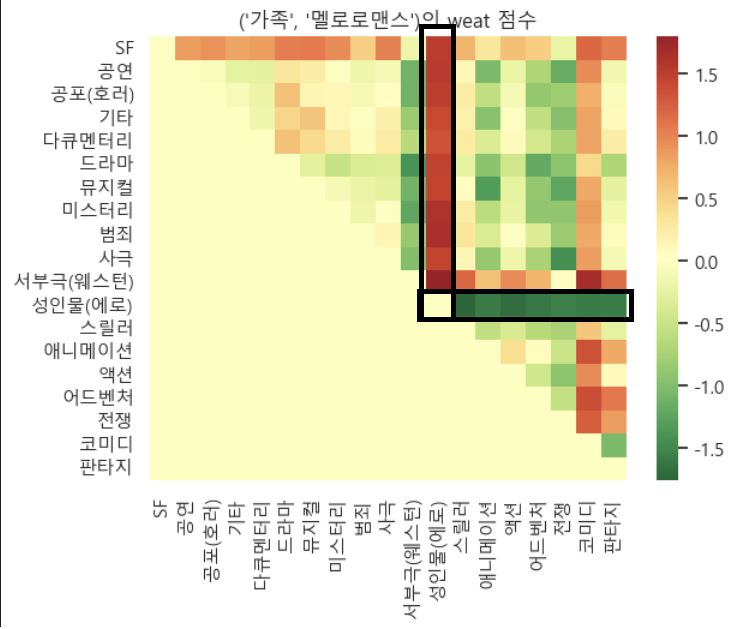


2. 또 재미있던 거는 위처럼 어떤 장르가 편향성이 큰데, 같은방향으로 편향성이 큰 다른 장르와 매치가 되면 weat가 0이 된걸 볼 수 있었다. target(가족, 전쟁) 장르에 편향성에서 이를 쉽게 볼 수 있는데, atrribute(sf)는 다른 어떤 장르와 매치되어도 전쟁에 가깝게 편향이 있었고, 비슷하게 atrribute(범죄) 역시 다른 어떤 장르와 매치되어도 전쟁에 가깝게 편향이 있었다. 그래서 target(가족, 전쟁)에 대하여 atrribute(sf, 범죄)는 0에 가깝게 나타났다. 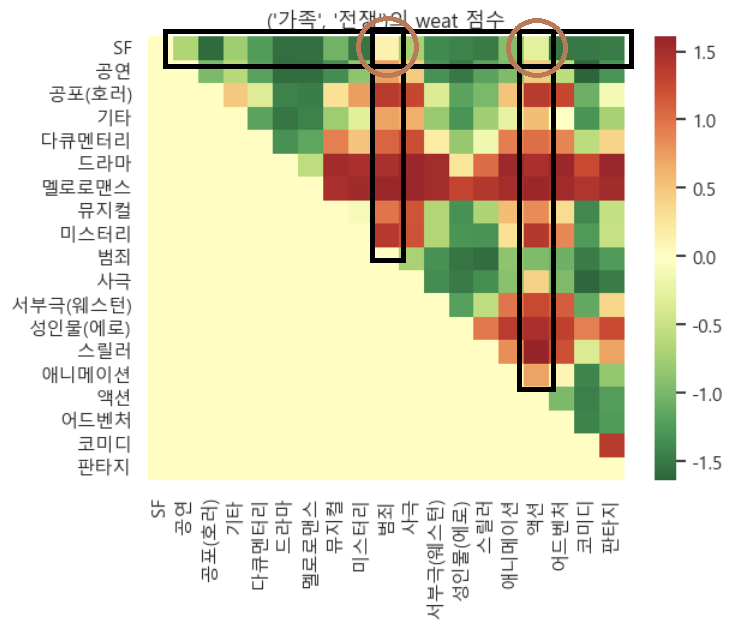

이 경우 처음 weat를 공부하면서 예측하던 문제이기도 했다. weat 점수가 낮을 때 가능한 경우를 따져보니 3가지 정도를 생각할 수 있었고, 구체적으로는 편향성이 적거나 없는 경우, 타겟들의 편향성이 존재해도 그 방향이 비슷한 경우, 한 타겟안의 단어가 서로 다른 방향으로 편향되어 타겟세트의 편향이 없어 보이는 경우였다. 2번 경우도 타겟들의 편향성이 존재해도 그 방향이 비슷한 경우로 사전에 생각하던 경우였다.


3. 어떤 큰 편향성이 다른 편향성을 잡아 먹은 경우도 볼 수 있었다. 이는 히트맵으로 같은 색상 줄이 그어졌는데, 다른 줄이 그 줄을 무시하고 그 위에다 색칠한 것처럼 그어져 있는 것으로 볼 수 있었다. target(공포, 멜로로멘스)에서 이를 쉽게 확인할 수 있는데,
   멜로로맨스가 attribute(성인물), attribute(코미디)과의 편향성이 너무 커서 가로줄로 초록색이 그어지는 현상속에서 빨간색으로 세로줄을 그어버리는 것을 볼 수 있다. 이런 와중에 attribute(성인물, 코미디)의 경우엔 성인물이 편향성이 너무 커서 코미디도 잡아 먹는 모습을 보여주고 있다. 
   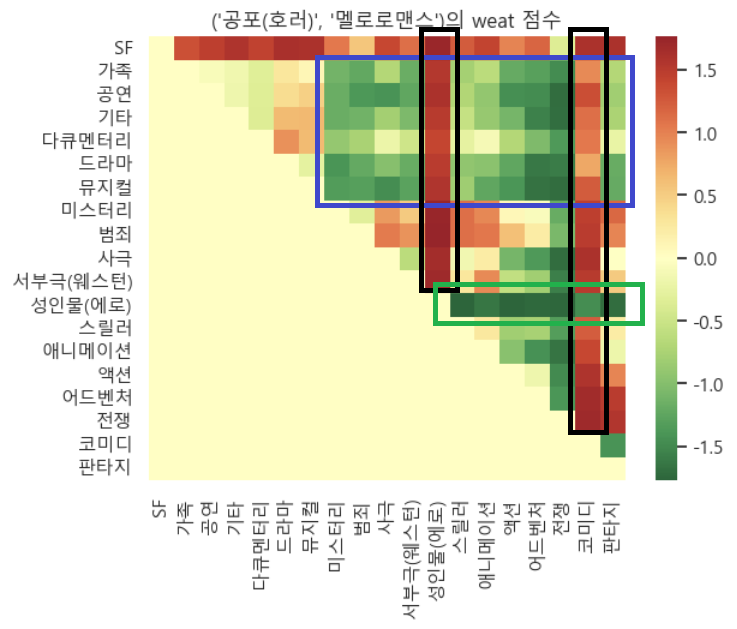


4. 중복이 있는 대표단어와 없는 대표단어의 차이를 보았는데, 중복이 없는 경우 편향성이 더 두드러지게 나타나는 형상이 있었다. 색이 더 진하게 나타나고, 첫번째 경우를 보면 코미디 관련 경우엔 중복이 있을 때는 편향성이 크지 않았는데, 중복을 제거하니 편향성이 나타나게 되었다. 아래의 히트맵 말고도 대부분 더 진한 색상을 띄고 있다.  

이 히트맵이 중복을 제거한 것이고  
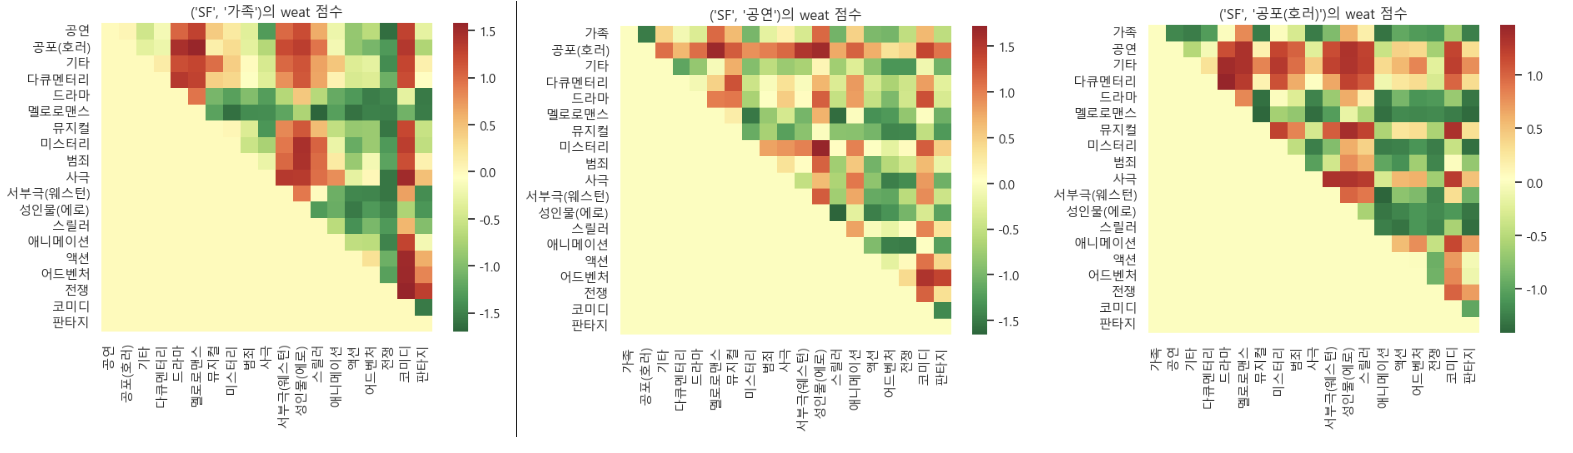
이 히트맵은 중복이 있는 것이다.  
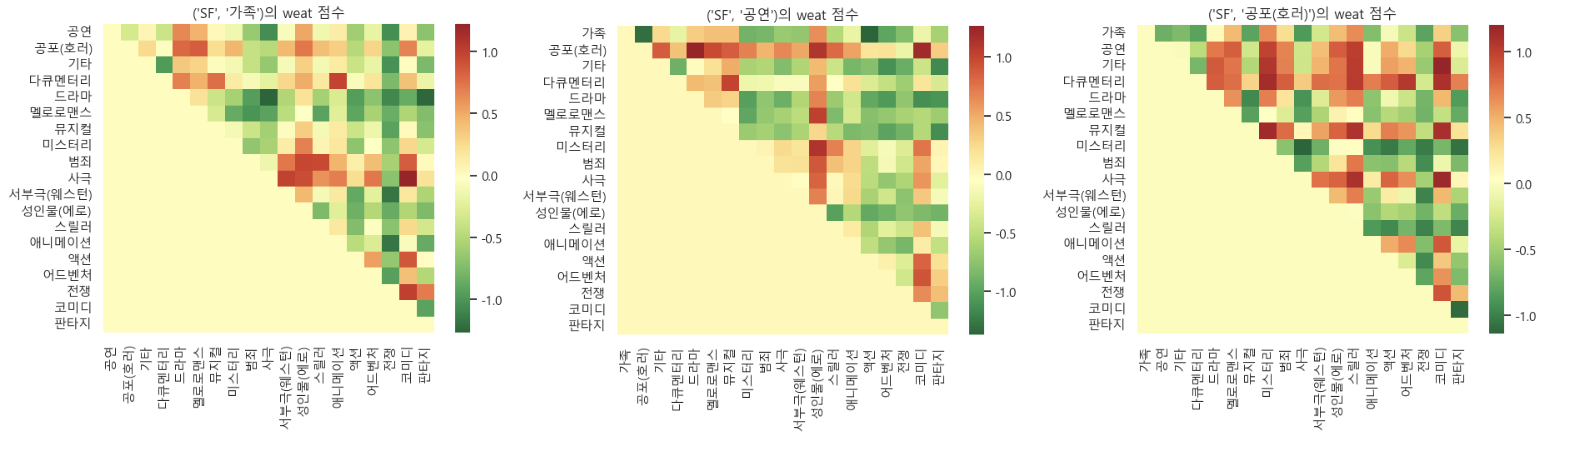

임베딩내에서 편향성이 무엇인지도 알겠고, 왜 생기는 지도 알겠고, 중요하다는 것도 알겠는데, weat 방식은 아직도 잘 이해가 안된다. 심리학의 IAT테스트에서 착안된 방법인 것은 알겠지만, IAT의 경우 사람의 무의식에서 존재하는 인지편향을 측정하는 방식이라 이런 복잡한 방식을 쓰지만, 임베딩의 경우 그냥 한 타겟에 대해서도 편향성을 수치로 계산이 가능한데 왜 이런 방식을 쓰는지 잘 이해가 안되었다. 물론 타겟이 둘이 되면 타겟 간의 편향의 정도와 방향을 비교할 수 있지만, 그것이 중요한 지는 아직 잘 와닫지가 않는다.


#### 기타. 중복단어가 있는 전체 히트맵


중복단어 있는 상태로 확인

시각화는 너무 길어져서 주석처리

In [ ]:
# 장르별 단어세트 구성, 중복 고려하지 않음
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)
# 각 장르(행)의 데이터를 COOrdinate format으로 변경
m = [
    X[i].tocoo() for i in range(X.shape[0])
]  # Compressed Sparse Row format -> COOrdinate format
# csr형식은 비제로 행만 접근 가능한데, COO 타입은 비제로 열도 접근 가능

# tf-idf행렬에서 .data 0이 아닌 연관도가 있는 것을 보아 .col로 단어의 인덱스를 가져옴
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

# tf-idf 점수 순으로 정렬
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []

# 각 장르별로 단어 추출
for i in range(len(w)):
    print(genre_name[i], end=": ")
    attr = []
    j = 0
    while len(attr) < 15:  # 상위 n개 단어만 추가
        # 단어사전[인덱스] 형식으로 디코딩
        # w[i][j][0]는 단어 인덱스, w[i][j][1]은 점수
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=", ")
        j += 1
    attributes.append(attr)

matrixes = []

for c in combinations:
    # 빈 행렬 초기화
    matrix = [
        [0 for _ in range(len(genre_name) - 2)] for _ in range(len(genre_name) - 2)
    ]

    # 타겟 단어 추출
    target_x = genre_name.index(c[0])
    X = np.array([model.wv[word] for word in attributes[target_x]])
    target_y = genre_name.index(c[1])
    Y = np.array([model.wv[word] for word in attributes[target_y]])

    attributes_temp = attributes.copy()
    del attributes_temp[max(target_x, target_y)]
    del attributes_temp[min(target_x, target_y)]

    # 각 속성에 대하여 weat구하기
    for i in range(len(genre_name) - 3):
        for j in range(i + 1, len(genre_name) - 2):
            A = np.array([model.wv[word] for word in attributes_temp[i]])
            B = np.array([model.wv[word] for word in attributes_temp[j]])
            matrix[i][j] = weat_score(X, Y, A, B)
    matrixes.append(matrix)

In [43]:
# for i, c in enumerate(combinations):
#     target_x = genre_name.index(c[0])
#     target_y = genre_name.index(c[1])

#     genre_name_temp = genre_name.copy()
#     del genre_name_temp[max(target_x, target_y)]
#     del genre_name_temp[min(target_x, target_y)]

#     ax = sns.heatmap(
#         matrixes[i],
#         xticklabels=genre_name_temp,
#         yticklabels=genre_name_temp,
#         # annot=True,
#         cmap="RdYlGn_r",
#     )
#     plt.title(f"{c}의 weat 점수")
#     plt.show()